## **Network Analysis of City Networks and Hospital Data**

Analysis of C2C and C2H networks.

In [3]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import text, inspect, MetaData

import powerlaw
from tqdm import tqdm
import numpy as np
from pathlib import Path
import pandas as pd
from itertools import product
import datetime as dt
from collections import defaultdict, Counter

from dateutil.relativedelta import relativedelta
from scipy.stats import linregress

import nxviz as nv
import networkx as nx
from networkx.algorithms import bipartite
from nxviz import layouts, plots, lines
from nxviz import nodes, edges, annotate, highlights
from nxviz.plots import despine, rescale, respine, aspect_equal

from nxviz.utils import edge_table, node_table
from nxviz import encodings as aes

import matplotlib
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Tahoma"]

basepath = Path.home().joinpath("Documents", "data")
netpath = basepath.joinpath("regulacao", "edgelists")

netpath_ne = basepath.joinpath("regulacao", "edgelists", "nordeste_no_service")

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


### **Functions**

In [4]:
def create_network(edgelist_df, net_type="c2c"):
    '''
    
    '''
    # -- default (c2c)
    if net_type=="c2c":
        source_nm, target_nm = "MUNIC_RES", "MUNIC_MOV" 
        graph = nx.DiGraph()
    elif net_type=="c2h":
        source_nm, target_nm = "MUNIC_RES", "CNES"
        graph = nx.DiGraph()
    elif net_type=="h2d":
        source_nm, target_nm = "CNES", "DIAG_CATEG"
        graph = nx.Graph() 
    elif net_type=="h2hs":
        source_nm, target_nm = "CNES", "SP_ATOPROF"
        graph = nx.Graph()
    elif net_type=="equip2hospital":
        source_nm, target_nm = "EQUIP_KEY", "CNES"
        graph = nx.Graph()
    elif net_type=="equip2mun":
        source_nm, target_nm = "EQUIP_KEY", "MUNIC_MOV"
        graph = nx.Graph()
    else:
        raise Exception("type not included.")  
        
    # Iterate through the dataframe and add edges with all edge attributes
    for idx, row in edgelist_df.iterrows():
        node_res = row[source_nm]
        node_mov = row[target_nm]
    
        # Get the edge attributes (all columns except the first two)
        edge_attributes = row.drop([source_nm, target_nm]).to_dict()
    
        # Add the edge with its attributes
        graph.add_edge(node_res, node_mov, **edge_attributes)
    return graph

def summarize_network(G, return_summary=True):
    summary = {}

    # Basic information
    summary['Number of Nodes'] = G.number_of_nodes()
    summary['Number of Edges'] = G.number_of_edges()
    summary['Is Directed'] = G.is_directed()
    summary['Is Bipartite'] = bipartite.is_bipartite(G)

    # Node and edge metadata keys
    if len(G.nodes) > 0:
        summary['Node Metadata Keys'] = list(next(iter(G.nodes(data=True)))[1].keys())
    else:
        summary['Node Metadata Keys'] = []

    if len(G.edges) > 0:
        summary['Edge Metadata Keys'] = list(next(iter(G.edges(data=True)))[2].keys())
    else:
        summary['Edge Metadata Keys'] = []

    # Degree information
    if G.is_directed():
        in_degrees = dict(G.in_degree())
        out_degrees = dict(G.out_degree())
        try:
            summary['Mean In-Degree'] = sum(in_degrees.values()) / len(in_degrees)
        except: pass
        try:
            summary['Mean Out-Degree'] = sum(out_degrees.values()) / len(out_degrees)
        except: pass
    else:
        degrees = dict(G.degree())
        summary['Mean Degree'] = sum(degrees.values()) / len(degrees)

    # Printing summary
    for key, value in summary.items():
        print(f"{key}: {value}")

    if return_summary:
        return summary
    
def log_binning(degree_sequence, num_bins=50):
    degree_counts = Counter(degree_sequence)
    degrees, counts = zip(*degree_counts.items())
    degrees = np.array(degrees)
    counts = np.array(counts)

    # Define bins in log space
    min_degree = np.log10(min(degrees))
    max_degree = np.log10(max(degrees))
    bins = np.logspace(min_degree, max_degree, num=num_bins)

    # Bin the data
    binned_degrees = []
    binned_counts = []
    for i in range(len(bins) - 1):
        mask = (degrees >= bins[i]) & (degrees < bins[i + 1])
        if np.sum(mask) > 0:
            binned_degrees.append(np.sqrt(bins[i] * bins[i + 1]))
            binned_counts.append(np.sum(counts[mask]))

    return np.array(binned_degrees), np.array(binned_counts)

In [5]:
def perform_query(query_str, engine, batchsize=1000):

    schema_data = {
        'rows': [],
        'columns': [],
    }

    query_str = text(query_str)
    with engine.connect() as conn:
        qres = conn.execute(query_str)
        schema_data['columns'] = list(qres.keys())

        while True:
            rows = qres.fetchmany(batchsize)
            if not rows:
                break
            schema_data["rows"] += [ row for row in rows ]
    
    res_df = pd.DataFrame(schema_data['rows'], columns=schema_data['columns'])
    return res_df

def select_period_aih(engine, start_date, final_date, diag_level=0):
    '''
        Filter the AIH records for the period selected and considering the 
        diagnostic level of information required.

        'diag_level' refers to the number of chars to be considered in the 
        diagnostic ICD-10 of a hospital admission.
    '''
    if diag_level>4:
        diag_level = 4
    elif diag_level<0:
        diag_level = 0
    
    query = f'''
        SELECT 
            N_AIH, CNES, MUNIC_RES, MUNIC_MOV, VAL_TOT,
            SUBSTR(DIAG_PRINC,1,{diag_level}) as DIAG_CATEG 
        FROM aih_reduzida
        WHERE DT_INTER >= '{start_date.strftime("%Y-%m-%d")}' AND DT_INTER <= '{final_date.strftime("%Y-%m-%d")}'
    '''
    df = perform_query(query, engine)
    return df

### **C2C networks**

In [3]:
datapath = netpath_ne
yy_left, yy_right = 2017, 2017

people_edgelist = pd.read_parquet(datapath.joinpath("c2c", f"c2c_diag_people_{yy_left}_{yy_right}.parquet")).reset_index()
money_edgelist = pd.read_parquet(datapath.joinpath("c2c", f"c2c_diag_money_{yy_left}_{yy_right}.parquet")).reset_index()
#service_edgelist = pd.read_parquet(datapath.joinpath("c2c", "c2c_service_2015_2017.parquet")).reset_index()

# -- only one state (in case we are performing the analysis over one state)
#state_uf = "23"
#people_edgelist = people_edgelist[(people_edgelist["MUNIC_RES"].str.contains("^23", regex=True)) & (people_edgelist["MUNIC_MOV"].str.contains("^23", regex=True))]
#money_edgelist = money_edgelist[(money_edgelist["MUNIC_RES"].str.contains("^23", regex=True)) & (money_edgelist["MUNIC_MOV"].str.contains("^23", regex=True))]
#service_edgelist = service_edgelist[(service_edgelist["MUNIC_RES"].str.contains("^23", regex=True)) & (service_edgelist["MUNIC_MOV"].str.contains("^23", regex=True))]

# -- filter fluxes only between northeast states 
ne_ufs = ["21", "22", "23", "24", "25", "26", "27", "28", "29"]
people_edgelist["CD_UF_RES"] = people_edgelist["MUNIC_RES"].apply(lambda x: x[:2])
people_edgelist["CD_UF_MOV"] = people_edgelist["MUNIC_MOV"].apply(lambda x: x[:2])
money_edgelist["CD_UF_RES"] = money_edgelist["MUNIC_RES"].apply(lambda x: x[:2])
money_edgelist["CD_UF_MOV"] = money_edgelist["MUNIC_MOV"].apply(lambda x: x[:2])
people_edgelist = people_edgelist[(people_edgelist["CD_UF_RES"].isin(ne_ufs)) & (people_edgelist["CD_UF_MOV"].isin(ne_ufs))]
money_edgelist = money_edgelist[(money_edgelist["CD_UF_RES"].isin(ne_ufs)) & (money_edgelist["CD_UF_MOV"].isin(ne_ufs))]

# -- generate the networks
net_people = create_network(people_edgelist, net_type='c2c')
net_money = create_network(money_edgelist, net_type='c2c')
#net_service = create_network(service_edgelist, net_type='c2c')

# -- generate the networks without self-loops
people_edgelist1 = people_edgelist[~(people_edgelist["MUNIC_RES"]==people_edgelist["MUNIC_MOV"])]
money_edgelist1 = money_edgelist[~(money_edgelist["MUNIC_RES"]==money_edgelist["MUNIC_MOV"])]
#service_edgelist1 = service_edgelist[~(service_edgelist["MUNIC_RES"]==service_edgelist["MUNIC_MOV"])]

# -- generate the networks
net_people_noself = create_network(people_edgelist1, net_type='c2c')
net_money_noself = create_network(money_edgelist1, net_type='c2c')
#net_service_noself = create_network(service_edgelist1, net_type='c2c')

print("With Self Loops:\n")
print('C2C People:\n')
summarize_network(net_people, return_summary=False)
print('C2C Money:\n')
summarize_network(net_money, return_summary=False)

print("No Self Loops:\n")
print('C2C People:\n')
summarize_network(net_people_noself, return_summary=False)
print('C2C Money:\n')
summarize_network(net_money_noself, return_summary=False)

With Self Loops:

C2C People:

Number of Nodes: 1794
Number of Edges: 23791
Is Directed: True
Is Bipartite: False
Node Metadata Keys: []
Edge Metadata Keys: ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A46', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A63', 'A64', 'A65', 'A66', 'A68', 'A69', 'A70', 'A71', 'A74', 'A77', 'A79', 'A80', 'A81', 'A82', 'A83', 'A84', 'A85', 'A86', 'A87', 'A88', 'A89', 'A90', 'A91', 'A92', 'A93', 'A94', 'A95', 'A96', 'A98', 'A99', 'B00', 'B01', 'B02', 'B03', 'B05', 'B06', 'B07', 'B08', 'B09', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B30', 'B33', 'B34', 'B35', 'B36', 'B37', 'B38', 'B39', 'B40', 'B41', 'B42', 'B43', 'B44', 'B45', 'B46', 'B

#### **Topology and Weights**

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahom

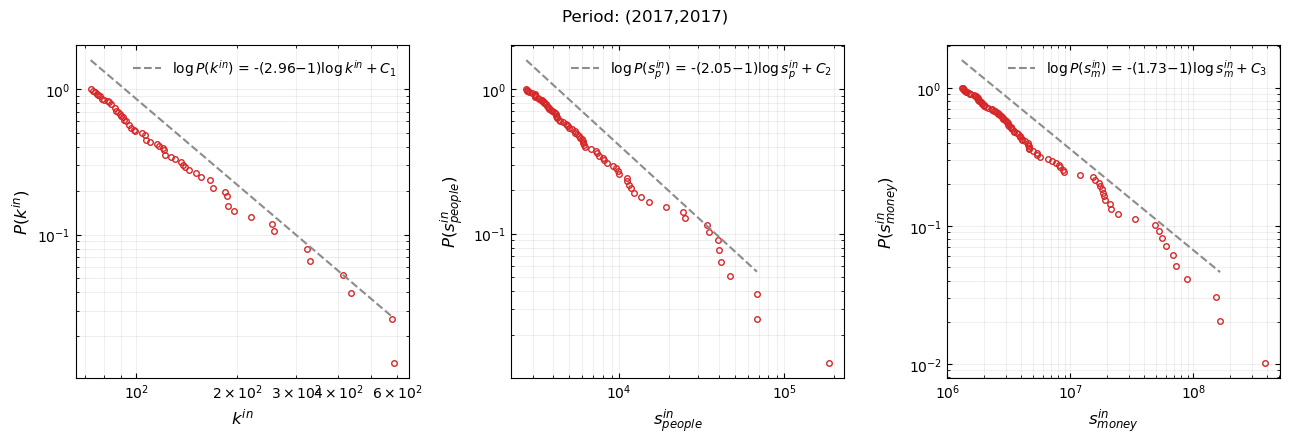

In [4]:
tol = 1e-8
in_deg_sequence = [ elem for elem in list(dict(net_people_noself.in_degree()).values()) if elem>0 ] 
in_people_sequence = [ elem for elem in list( {node: sum(data['SOMA'] for _, _, data in net_people_noself.in_edges(node, data=True)) for node in net_people_noself.nodes()}.values() ) if elem>0 ]
in_money_sequence = [ elem for elem in list( {node: sum(data['SOMA'] for _, _, data in net_money_noself.in_edges(node, data=True)) for node in net_money_noself.nodes()}.values() ) if elem>0 ]

fit_deg = powerlaw.Fit(in_deg_sequence)
fit_people = powerlaw.Fit(in_people_sequence)
fit_money = powerlaw.Fit(in_money_sequence)

deg_ccdf, deg_xmin, deg_alpha = fit_deg.ccdf(), fit_deg.power_law.xmin, fit_deg.power_law.alpha
people_ccdf, people_xmin, people_alpha = fit_people.ccdf(), fit_people.power_law.xmin, fit_people.power_law.alpha
money_ccdf, money_xmin, money_alpha = fit_money.ccdf(), fit_money.power_law.xmin, fit_money.power_law.alpha

# -- calculate prefactor of ccdf
C_deg = 1/deg_xmin
C_people = (people_alpha - 1)/deg_xmin
C_money = (money_alpha - 1)/deg_xmin

# -- figure
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,4.5))

ax1.plot(deg_ccdf[0], deg_ccdf[1], color="tab:red", ls='', marker='o', ms=4, mfc='none')
ax2.plot(people_ccdf[0], people_ccdf[1], color="tab:red", ls='', marker='o', ms=4, mfc='none')
ax3.plot(money_ccdf[0], money_ccdf[1], color="tab:red", ls='', marker='o', ms=4, mfc='none')

deg_fit_x, deg_fit_y = fit_deg.data[fit_deg.data >= fit_deg.power_law.xmin], fit_deg.power_law.ccdf()*(10**0.2)
people_fit_x, people_fit_y = fit_people.data[fit_people.data >= fit_people.power_law.xmin], fit_people.power_law.ccdf()*(10**0.2)
money_fit_x, money_fit_y = fit_money.data[fit_money.data >= fit_money.power_law.xmin], fit_money.power_law.ccdf()*(10**0.2)
ax1.plot(deg_fit_x[:-1], deg_fit_y[:-1], ls="--", color="#8c8c8c", lw=1.5, label=r"$\log P(k^{in})$ = -"+f"({deg_alpha:.2f}"+r"$-1)\log k^{in} + C_1$")
ax2.plot(people_fit_x[:-1], people_fit_y[:-1], ls="--", color="#8c8c8c", lw=1.5, label=r"$\log P(s_p^{in})$ = -"+f"({people_alpha:.2f}"+r"$-1)\log s_p^{in} + C_2$")
ax3.plot(money_fit_x[:-1], money_fit_y[:-1], ls="--", color="#8c8c8c", lw=1.5, label=r"$\log P(s_m^{in})$ = -"+f"({money_alpha:.2f}"+r"$-1)\log s_m^{in} + C_3$")

for axis in [ax1, ax2, ax3]:
    axis.legend(frameon=False)
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.grid(alpha=0.2, which='both')
    axis.tick_params(which='both', direction='in', top=True, right=True)

ax1.set_xlabel(r'$k^{in}$', fontsize=12)
ax2.set_xlabel(r'$s_{people}^{in}$', fontsize=12)
ax3.set_xlabel(r'$s_{money}^{in}$', fontsize=12)
ax1.set_ylabel(r'$P(k^{in})$', fontsize=12)
ax2.set_ylabel(r'$P(s_{people}^{in})$', fontsize=12)
ax3.set_ylabel(r'$P(s_{money}^{in})$', fontsize=12)

fig.suptitle(f"Period: ({yy_left},{yy_right})")

fig.tight_layout()
#fig.savefig(basepath.joinpath("regulacao", "figs", f"cdf_influx_deg_people_money_{yy_left}_{yy_right}.png"), dpi=250, bbox_inches='tight')

In [91]:
#fit_deg.plot_ccdf(color='b', linewidth=2)
#fit_deg.power_law.plot_ccdf(color='r', linestyle='--')
fit_people.xmax

### **C2H networks**

### **CNES data**

#### **Query functions**

In [9]:
def quant_leitos_per_cnes(date, engine):
    '''
        Do not consider the type of the hospital bed.
    '''
    date_fmt = date.strftime("%Y-%m-%d")
    q = f'''
        SELECT
            a.*,
            b.CODUFMUN
        FROM (
            SELECT 
                CNES, SUM(QT_EXIST) as QUANT_LEITOS, SUM(QT_SUS) as QUANT_LEITOS_SUS 
            FROM leitos_mes WHERE COMPET = '{date_fmt} 00:00:00.000000'
            GROUP BY CNES
        ) a
        LEFT JOIN cnes b
        ON a.CNES = b.CNES
    '''
    df = perform_query(q, engine).sort_values(by="QUANT_LEITOS", ascending=False)
    return df

def quant_leitos_per_mun(date, engine):
    '''
        Do not consider the type of the hospital bed.
    '''
    date_fmt = date.strftime("%Y-%m-%d")
    q = f'''
        SELECT
            CODUFMUN, SUM(QUANT_LEITOS) as QUANT_LEITOS,
            SUM(QUANT_LEITOS_SUS) as QUANT_LEITOS_SUS
        FROM (
            SELECT
                a.*, b.CODUFMUN
            FROM (
                SELECT 
                    CNES, SUM(QT_EXIST) as QUANT_LEITOS, SUM(QT_SUS) as QUANT_LEITOS_SUS 
                FROM leitos_mes WHERE COMPET = '{date_fmt} 00:00:00.000000'
                GROUP BY CNES
            ) a
            LEFT JOIN cnes b
            ON a.CNES = b.CNES
        )
        GROUP BY CODUFMUN
    '''
    df = perform_query(q, engine).sort_values(by="QUANT_LEITOS", ascending=False)
    return df

def quant_equip_per_cnes(date, engine):
    '''
        Do not consider the type of the equipament.
    '''
    date_fmt = date.strftime("%Y-%m-%d")
    q = f'''
        SELECT
            a.*,
            b.CODUFMUN
        FROM (
            SELECT 
                CNES, SUM(QT_EXIST) as QUANT_EQUIP
            FROM equipamentos_mes WHERE COMPET = '{date_fmt} 00:00:00.000000' AND IND_SUS = 1
            GROUP BY CNES
        ) a
        LEFT JOIN cnes b
        ON a.CNES = b.CNES
    '''
    df = perform_query(q, engine)
    return df

def quant_equip_per_mun(date, engine, ind_sus=True):
    '''
        Do not consider the type of the equipament.
    '''
    date_fmt = date.strftime("%Y-%m-%d")
    ind_sus_v = 1
    if not ind_sus:
        ind_sus_v = 0
    q = f'''
        SELECT
            CODUFMUN, SUM(QUANT_EQUIP) as QUANT_EQUIP
        FROM (
            SELECT
                a.*, b.CODUFMUN
            FROM (
                SELECT 
                    CNES, SUM(QT_EXIST) as QUANT_EQUIP
                FROM equipamentos_mes WHERE COMPET = '{date_fmt} 00:00:00.000000' AND IND_SUS = {ind_sus_v}
                GROUP BY CNES
            ) a
            LEFT JOIN cnes b
            ON a.CNES = b.CNES
        )
        GROUP BY CODUFMUN
    '''
    df = perform_query(q, engine)
    return df

def quant_profissionais_per_cnes(date, engine, prof_sus=True):
    '''
    
    '''
    date_fmt = date.strftime("%Y-%m-%d")
    prof_sus_v = 1
    if not prof_sus:
        prof_sus_v = 0
    q = f'''
        SELECT
            a.*,
            b.CODUFMUN
        FROM (
            SELECT 
                CNES, COUNT(CNS_PROF) as QUANT_PROFISSIONAIS
            FROM profissionais_mes WHERE COMPET = '{date_fmt} 00:00:00.000000' AND PROF_SUS = {prof_sus_v}
            GROUP BY CNES
        ) a
        LEFT JOIN cnes b
        ON a.CNES = b.CNES
    '''
    df = perform_query(q, engine)
    return df

def quant_profissionais_per_mun(date, engine, prof_sus=True):
    '''
        Do not consider the type of the equipament.
    '''
    date_fmt = date.strftime("%Y-%m-%d")
    prof_sus_v = 1
    if not prof_sus:
        prof_sus_v = 0
    q = f'''
        SELECT
            CODUFMUN, SUM(QUANT_PROFISSIONAIS) as QUANT_PROFISSIONAIS
        FROM (
            SELECT
                a.*, b.CODUFMUN
            FROM (
                SELECT 
                    CNES, COUNT(CNS_PROF) as QUANT_PROFISSIONAIS
                FROM profissionais_mes WHERE COMPET = '{date_fmt} 00:00:00.000000' AND PROF_SUS = {prof_sus_v}
                GROUP BY CNES
            ) a
            LEFT JOIN cnes b
            ON a.CNES = b.CNES
        )
        GROUP BY CODUFMUN
    '''
    df = perform_query(q, engine)
    return df

#### **Probability Distributions of Health Resources**

In [8]:
# -- connect with the CNES database
dbpath = Path.home().joinpath("Documents", "data", "opendatasus", "cnes")
cnes_name = "CNES_NORDESTE.db"

cnes_engine_url = f"sqlite:///{dbpath.joinpath(cnes_name)}"
cnes_engine = create_engine(cnes_engine_url)

# -- access test
q = f'''
    SELECT * FROM cnes LIMIT 5
'''
df = perform_query(q, cnes_engine)
df.head(4)

,CNES,CODUFMUN,COD_CEP,CPF_CNPJ,PF_PJ,VINC_SUS,TPGESTAO,ESFERA_A,NATUREZA,TP_UNID,NIV_HIER,TP_PREST,LATITUDE,LONGITUDE
0,2793970,270890,57120000,00000000000000,3,1,M,03,01,02,01,50,None,None
1,2005255,270030,57312620,00000000000000,3,1,M,03,01,02,03,50,None,None
2,2010453,270550,57820000,00000000000000,3,1,M,03,01,22,02,50,None,None
3,2008572,270010,57490000,00000000000000,3,1,M,03,01,01,01,50,None,None


In [10]:
# -- date
date = dt.date(2019,1,1)

cnes_leitos_df = quant_leitos_per_cnes(date, cnes_engine)
cnes_equip_df = quant_equip_per_cnes(date, cnes_engine)
mun_leitos_df = quant_leitos_per_mun(date, cnes_engine)
mun_equip_df = quant_equip_per_mun(date, cnes_engine)
cnes_prof_df = quant_profissionais_per_cnes(date, cnes_engine)
mun_prof_df = quant_profissionais_per_mun(date, cnes_engine)

In [11]:
print(mun_leitos_df.shape[0], mun_equip_df.shape[0], mun_prof_df.shape[0])

mun_equip_df = mun_equip_df.sort_values(by="CODUFMUN")
mun_leitos_df = mun_leitos_df.sort_values(by="CODUFMUN")
mun_prof_df = mun_prof_df.sort_values(by="CODUFMUN")

resources_df = mun_prof_df.merge(mun_equip_df, how="left").merge(mun_leitos_df, how="left").fillna(0)
resources_df["N_LEITOS_EQUIP"] = resources_df["QUANT_EQUIP"] + resources_df["QUANT_LEITOS"]
resources_df["N_TODOS"] = resources_df["QUANT_EQUIP"] + resources_df["QUANT_LEITOS"] + resources_df["QUANT_PROFISSIONAIS"]
resources_df

1332 1794 1794


,CODUFMUN,QUANT_PROFISSIONAIS,QUANT_EQUIP,QUANT_LEITOS,QUANT_LEITOS_SUS,N_LEITOS_EQUIP,N_TODOS
0,210005,1087,369,214.0,124.0,583.0,1670.0
1,210010,80,27,15.0,15.0,42.0,122.0
2,210015,100,27,0.0,0.0,27.0,127.0
3,210020,207,13,24.0,24.0,37.0,244.0
4,210030,216,17,25.0,25.0,42.0,258.0
...,...,...,...,...,...,...,...
1789,293330,5654,1123,1184.0,766.0,2307.0,7961.0
1790,293340,117,32,37.0,37.0,69.0,186.0
1791,293345,159,13,30.0,30.0,43.0,202.0
1792,293350,255,72,44.0,44.0,116.0,371.0


In [ ]:
tol = 1e-8
in_deg_sequence = [ elem for elem in list(dict(net_people_noself.in_degree()).values()) if elem>0 ] 
in_people_sequence = [ elem for elem in list( {node: sum(data['SOMA'] for _, _, data in net_people_noself.in_edges(node, data=True)) for node in net_people_noself.nodes()}.values() ) if elem>0 ]
in_money_sequence = [ elem for elem in list( {node: sum(data['SOMA'] for _, _, data in net_money_noself.in_edges(node, data=True)) for node in net_money_noself.nodes()}.values() ) if elem>0 ]

fit_deg = powerlaw.Fit(in_deg_sequence)
fit_people = powerlaw.Fit(in_people_sequence)
fit_money = powerlaw.Fit(in_money_sequence)

deg_ccdf, deg_xmin, deg_alpha = fit_deg.ccdf(), fit_deg.power_law.xmin, fit_deg.power_law.alpha
people_ccdf, people_xmin, people_alpha = fit_people.ccdf(), fit_people.power_law.xmin, fit_people.power_law.alpha
money_ccdf, money_xmin, money_alpha = fit_money.ccdf(), fit_money.power_law.xmin, fit_money.power_law.alpha

# -- calculate prefactor of ccdf
C_deg = 1/deg_xmin
C_people = (people_alpha - 1)/deg_xmin
C_money = (money_alpha - 1)/deg_xmin

# -- figure
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,4.5))

ax1.plot(deg_ccdf[0], deg_ccdf[1], color="tab:red", ls='', marker='o', ms=4, mfc='none')
ax2.plot(people_ccdf[0], people_ccdf[1], color="tab:red", ls='', marker='o', ms=4, mfc='none')
ax3.plot(money_ccdf[0], money_ccdf[1], color="tab:red", ls='', marker='o', ms=4, mfc='none')

deg_fit_x, deg_fit_y = fit_deg.data[fit_deg.data >= fit_deg.power_law.xmin], fit_deg.power_law.ccdf()*(10**0.2)
people_fit_x, people_fit_y = fit_people.data[fit_people.data >= fit_people.power_law.xmin], fit_people.power_law.ccdf()*(10**0.2)
money_fit_x, money_fit_y = fit_money.data[fit_money.data >= fit_money.power_law.xmin], fit_money.power_law.ccdf()*(10**0.2)
ax1.plot(deg_fit_x[:-1], deg_fit_y[:-1], ls="--", color="#8c8c8c", lw=1.5, label=r"$\log P(k^{in})$ = -"+f"({deg_alpha:.2f}"+r"$-1)\log k^{in} + C_1$")
ax2.plot(people_fit_x[:-1], people_fit_y[:-1], ls="--", color="#8c8c8c", lw=1.5, label=r"$\log P(s_p^{in})$ = -"+f"({people_alpha:.2f}"+r"$-1)\log s_p^{in} + C_2$")
ax3.plot(money_fit_x[:-1], money_fit_y[:-1], ls="--", color="#8c8c8c", lw=1.5, label=r"$\log P(s_m^{in})$ = -"+f"({money_alpha:.2f}"+r"$-1)\log s_m^{in} + C_3$")

for axis in [ax1, ax2, ax3]:
    axis.legend(frameon=False)
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.grid(alpha=0.2, which='both')
    axis.tick_params(which='both', direction='in', top=True, right=True)

ax1.set_xlabel(r'$k^{in}$', fontsize=12)
ax2.set_xlabel(r'$s_{people}^{in}$', fontsize=12)
ax3.set_xlabel(r'$s_{money}^{in}$', fontsize=12)
ax1.set_ylabel(r'$P(k^{in})$', fontsize=12)
ax2.set_ylabel(r'$P(s_{people}^{in})$', fontsize=12)
ax3.set_ylabel(r'$P(s_{money}^{in})$', fontsize=12)

fig.suptitle(f"Period: ({yy_left},{yy_right})")

fig.tight_layout()
#fig.savefig(basepath.joinpath("regulacao", "figs", f"cdf_influx_deg_people_money_{yy_left}_{yy_right}.png"), dpi=250, bbox_inches='tight')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

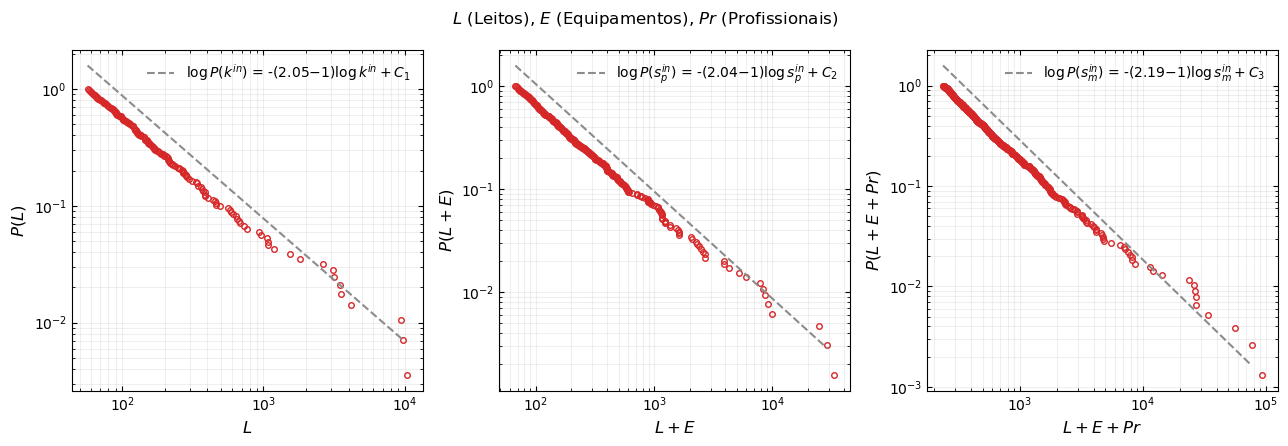

In [15]:
tol = 1e-8
in_deg_sequence_1 = [ elem for elem in resources_df['QUANT_LEITOS'].values if elem > 0 ]
in_deg_sequence_2 = [ elem for elem in resources_df['N_LEITOS_EQUIP'].values if elem > 0 ]
in_deg_sequence_3 = [ elem for elem in resources_df['N_TODOS'].values if elem > 0 ]

fit1 = powerlaw.Fit(in_deg_sequence_1)
fit2 = powerlaw.Fit(in_deg_sequence_2)
fit3 = powerlaw.Fit(in_deg_sequence_3)

fit1_ccdf, fit1_xmin, fit1_alpha = fit1.ccdf(), fit1.power_law.xmin, fit1.power_law.alpha
fit2_ccdf, fit2_xmin, fit2_alpha = fit2.ccdf(), fit2.power_law.xmin, fit2.power_law.alpha
fit3_ccdf, fit3_xmin, fit3_alpha = fit3.ccdf(), fit3.power_law.xmin, fit3.power_law.alpha

# -- figure
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,4.5))

ax1.plot(fit1_ccdf[0], fit1_ccdf[1], color="tab:red", ls='', marker='o', ms=4, mfc='none')
ax2.plot(fit2_ccdf[0], fit2_ccdf[1], color="tab:red", ls='', marker='o', ms=4, mfc='none')
ax3.plot(fit3_ccdf[0], fit3_ccdf[1], color="tab:red", ls='', marker='o', ms=4, mfc='none')

fit1_fit_x, fit1_fit_y = fit1.data[fit1.data >= fit1.power_law.xmin], fit1.power_law.ccdf()*(10**0.2)
fit2_fit_x, fit2_fit_y = fit2.data[fit2.data >= fit2.power_law.xmin], fit2.power_law.ccdf()*(10**0.2)
fit3_fit_x, fit3_fit_y = fit3.data[fit3.data >= fit3.power_law.xmin], fit3.power_law.ccdf()*(10**0.2)
ax1.plot(fit1_fit_x[:-1], fit1_fit_y[:-1], ls="--", color="#8c8c8c", lw=1.5, label=r"$\log P(k^{in})$ = -"+f"({fit1_alpha:.2f}"+r"$-1)\log k^{in} + C_1$")
ax2.plot(fit2_fit_x[:-1], fit2_fit_y[:-1], ls="--", color="#8c8c8c", lw=1.5, label=r"$\log P(s_p^{in})$ = -"+f"({fit2_alpha:.2f}"+r"$-1)\log s_p^{in} + C_2$")
ax3.plot(fit3_fit_x[:-1], fit3_fit_y[:-1], ls="--", color="#8c8c8c", lw=1.5, label=r"$\log P(s_m^{in})$ = -"+f"({fit3_alpha:.2f}"+r"$-1)\log s_m^{in} + C_3$")

for axis in [ax1, ax2, ax3]:
    axis.legend(frameon=False)
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.grid(alpha=0.2, which='both')
    axis.tick_params(which='both', direction='in', top=True, right=True)

ax1.set_xlabel(r'$L$', fontsize=12)
ax2.set_xlabel(r'$L+E$', fontsize=12)
ax3.set_xlabel(r'$L+E+Pr$', fontsize=12)
ax1.set_ylabel(r'$P(L)$', fontsize=12)
ax2.set_ylabel(r'$P(L+E)$', fontsize=12)
ax3.set_ylabel(r'$P(L+E+Pr)$', fontsize=12)

fig.suptitle(r'$L$ (Leitos), $E$ (Equipamentos), $Pr$ (Profissionais)')

fig.tight_layout()

### **Dependence between degree/in flux strength and health resources**

In [16]:
in_deg_df = pd.DataFrame.from_dict(dict(net_people_noself.in_degree()), orient='index', columns=["In-Degree"])

in_strength_dict = {node: sum(data['SOMA'] for _, _, data in net_people_noself.in_edges(node, data=True)) for node in net_people_noself.nodes()}
in_strength_df = pd.DataFrame.from_dict(in_strength_dict, orient='index', columns=["In-Strength (People)"])

in_money_dict = {node: sum(data['SOMA'] for _, _, data in net_money_noself.in_edges(node, data=True)) for node in net_money_noself.nodes()}
in_money_df = pd.DataFrame.from_dict(in_money_dict, orient='index', columns=["In-Strength (Money)"])

mun_in_flux_df = in_deg_df.merge(in_strength_df, left_index=True, right_index=True).merge(in_money_df, left_index=True, right_index=True).reset_index().rename({"index": "CODUFMUN"}, axis=1)
mun_general_df = mun_in_flux_df.merge(resources_df, how="left")
mun_general_df

,CODUFMUN,In-Degree,In-Strength (People),In-Strength (Money),QUANT_PROFISSIONAIS,QUANT_EQUIP,QUANT_LEITOS,QUANT_LEITOS_SUS,N_LEITOS_EQUIP,N_TODOS
0,210005,21,1183.0,640067.93,1087,369,214.0,124.0,583.0,1670.0
1,210047,65,311.0,93265.43,287,124,36.0,36.0,160.0,447.0
2,210060,33,184.0,85155.89,675,97,81.0,76.0,178.0,853.0
3,210087,29,101.0,42026.67,123,24,17.0,17.0,41.0,164.0
4,210095,36,182.0,67286.12,273,10,58.0,58.0,68.0,341.0
...,...,...,...,...,...,...,...,...,...,...
1789,293170,0,0.0,0.00,110,59,0.0,0.0,59.0,169.0
1790,293245,0,0.0,0.00,141,6,5.0,5.0,11.0,152.0
1791,293270,0,0.0,0.00,187,27,0.0,0.0,27.0,214.0
1792,293317,0,0.0,0.00,89,10,0.0,0.0,10.0,99.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma


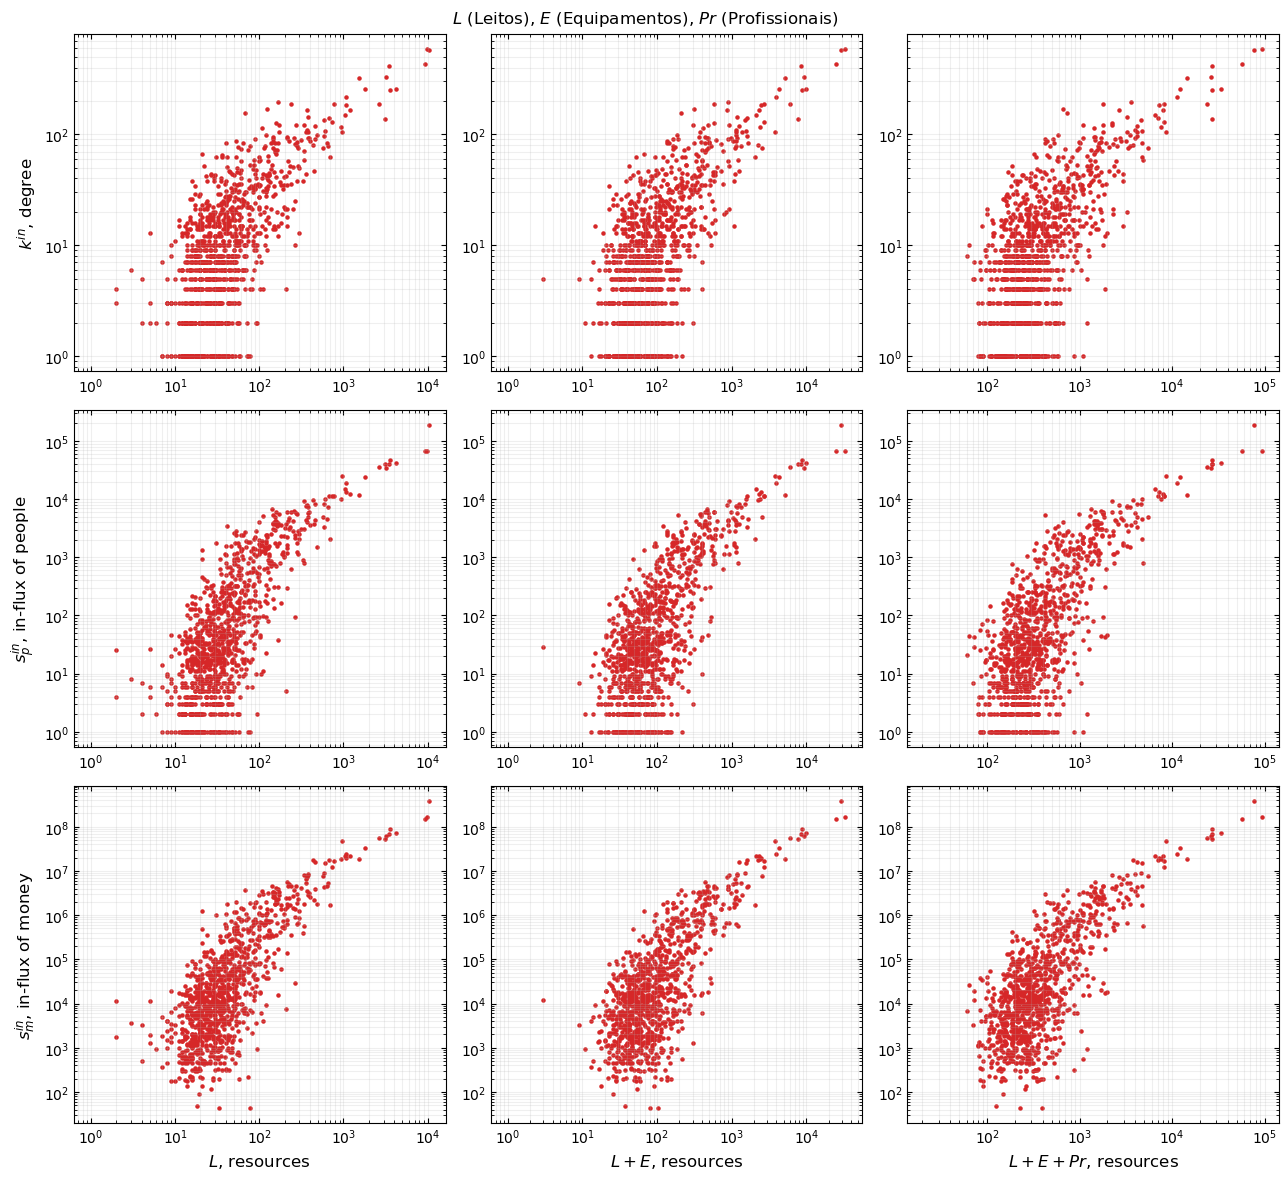

In [17]:
fig, AXS = plt.subplots(3,3, figsize=(13,12))

AXS[0,0].scatter(mun_general_df['QUANT_LEITOS'], mun_general_df["In-Degree"], color="tab:red", s=5, ls='-', marker='o')
AXS[0,1].scatter(mun_general_df['N_LEITOS_EQUIP'], mun_general_df["In-Degree"], color="tab:red", s=5, ls='-', marker='o')
AXS[0,2].scatter(mun_general_df['N_TODOS'], mun_general_df["In-Degree"], color="tab:red", s=5, ls='-', marker='o')

AXS[1,0].scatter(mun_general_df['QUANT_LEITOS'], mun_general_df["In-Strength (People)"], color="tab:red", s=5, ls='-', marker='o')
AXS[1,1].scatter(mun_general_df['N_LEITOS_EQUIP'], mun_general_df["In-Strength (People)"], color="tab:red", s=5, ls='-', marker='o')
AXS[1,2].scatter(mun_general_df['N_TODOS'], mun_general_df["In-Strength (People)"], color="tab:red", s=5, ls='-', marker='o')

AXS[2,0].scatter(mun_general_df['QUANT_LEITOS'], mun_general_df["In-Strength (Money)"], color="tab:red", s=5, ls='-', marker='o')
AXS[2,1].scatter(mun_general_df['N_LEITOS_EQUIP'], mun_general_df["In-Strength (Money)"], color="tab:red", s=5, ls='-', marker='o')
AXS[2,2].scatter(mun_general_df['N_TODOS'], mun_general_df["In-Strength (Money)"], color="tab:red", s=5, ls='-', marker='o')

for axis in [AXS[0,0], AXS[0,1], AXS[0,2], AXS[1,0], AXS[1,1], AXS[1,2], AXS[2,0], AXS[2,1], AXS[2,2]]:
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.grid(alpha=0.2, which='both')
    axis.tick_params(which='both', direction='in', top=True, right=True)

AXS[2,0].set_xlabel(r'$L$, resources', fontsize=12)
AXS[2,1].set_xlabel(r'$L+E$, resources', fontsize=12)
AXS[2,2].set_xlabel(r'$L+E+Pr$, resources', fontsize=12)
AXS[0,0].set_ylabel(r'$k^{in}$, degree', fontsize=12)
AXS[1,0].set_ylabel(r'$s_p^{in}$, in-flux of people', fontsize=12)
AXS[2,0].set_ylabel(r'$s_m^{in}$, in-flux of money', fontsize=12)

fig.suptitle(r'$L$ (Leitos), $E$ (Equipamentos), $Pr$ (Profissionais)')
fig.tight_layout()

### **Ranking of Diseases**

In [44]:
pop_df = pd.read_excel(basepath.joinpath("shapefilesceqgis", "estimativa_dou_2024.xls"), sheet_name="MUNICÍPIOS", header=1)[:-2]
pop_df["COD. UF"] = pop_df["COD. UF"].apply(lambda x: f"{x:2.0f}")
pop_df["COD. MUNIC"] = pop_df["COD. MUNIC"].apply(lambda x: f"{x:5.0f}".replace(" ", "0"))
pop_df["CODMUN"] = pop_df["COD. UF"]+pop_df["COD. MUNIC"]
pop_df["CODMUN"] = pop_df["CODMUN"].apply(lambda x: x[:6])
pop_df

,UF,COD. UF,COD. MUNIC,NOME DO MUNICÍPIO,POPULAÇÃO ESTIMADA,CODMUN
0,RO,11,00015,Alta Floresta D'Oeste,22853.0,110001
1,RO,11,00023,Ariquemes,108573.0,110002
2,RO,11,00031,Cabixi,5690.0,110003
3,RO,11,00049,Cacoal,97637.0,110004
4,RO,11,00056,Cerejeiras,16975.0,110005
...,...,...,...,...,...,...
5565,GO,52,22005,Vianópolis,15476.0,522200
5566,GO,52,22054,Vicentinópolis,9077.0,522205
5567,GO,52,22203,Vila Boa,4185.0,522220
5568,GO,52,22302,Vila Propício,5982.0,522230


In [9]:
# -- connect with the CNES database
dbpath = Path.home().joinpath("Documents", "data", "opendatasus")
sihsus_name = "SIHSUS_NORDESTE_NO_SERVICE.db"

sihsus_engine_url = f"sqlite:///{dbpath.joinpath(sihsus_name)}"
sihsus_engine = create_engine(sihsus_engine_url)

# -- access test
q = f'''
    SELECT * FROM aih_reduzida LIMIT 5
'''
df = perform_query(q, sihsus_engine)
df.head(4)

,N_AIH,UF_ZI,ANO_CMPT,MES_CMPT,ESPEC,IDENT,MUNIC_RES,NASC,SEXO,UTI_MES_TO,...,MORTE,NACIONAL,CAR_INT,GESTOR_COD,GESTOR_TP,CNES,CID_MORTE,COMPLEX,FINANC,FONTE
0,2308100006069,230000,2008,01,03,1,230540,1928-03-15 00:00:00.000000,3,0,...,0,010,02,None,0,2611309,None,02,06,CE0801
1,2308100006080,230000,2008,01,03,1,230540,1982-01-17 00:00:00.000000,1,0,...,0,010,02,None,0,2611309,None,02,06,CE0801
2,2308100006102,230000,2008,01,03,1,230540,1979-08-02 00:00:00.000000,3,0,...,0,010,02,None,0,2611309,None,02,06,CE0801
3,2308100006146,230000,2008,01,03,1,230540,1929-04-01 00:00:00.000000,3,0,...,0,010,02,None,0,2611309,None,02,06,CE0801


In [45]:
df = select_period_aih(sihsus_engine, dt.date(2015, 1, 1), dt.date(2019, 12, 31), diag_level=3)

In [34]:
ibge_codes_northeast_capitals = [
    '280030',  # Aracaju (Sergipe)
    '230440',  # Fortaleza (Ceará)
    '250750',  # João Pessoa (Paraíba)
    '270430',  # Maceió (Alagoas)
    '240810',  # Natal (Rio Grande do Norte)
    '261160',  # Recife (Pernambuco)
    '292740',  # Salvador (Bahia)
    '211130',  # São Luís (Maranhão)
    '221100'   # Teresina (Piauí)
]

df_capitais = df[df["MUNIC_MOV"].isin(ibge_codes_northeast_capitals)]
df_resto = df[~df["MUNIC_MOV"].isin(ibge_codes_northeast_capitals)]

In [35]:
count_all = df["DIAG_CATEG"].value_counts().reset_index()
count_capitais = df_capitais["DIAG_CATEG"].value_counts().reset_index()
count_resto = df_resto["DIAG_CATEG"].value_counts().reset_index()
for cur_df in [count_all, count_capitais, count_resto]:
    cur_df["ranking"] = [ n+1 for n in range(cur_df.shape[0]) ]

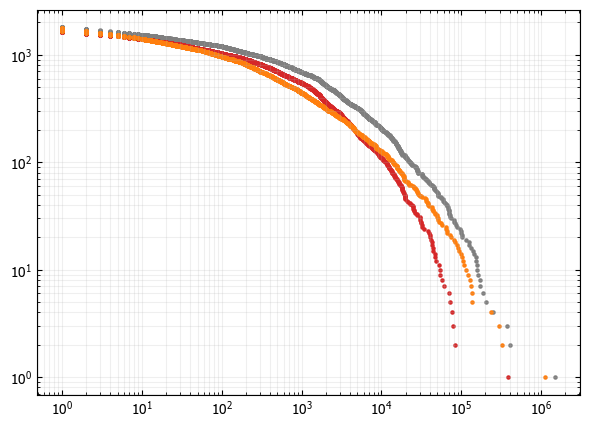

In [36]:
fig, ax1 = plt.subplots(1,1, figsize=(7,5))

ax1.scatter(count_all['count'], count_all["ranking"], color="tab:gray", s=5, ls='-', marker='o')
ax1.scatter(count_capitais['count'], count_capitais["ranking"], color="tab:red", s=5, ls='-', marker='o')
ax1.scatter(count_resto['count'], count_resto["ranking"], color="tab:orange", s=5, ls='-', marker='o')

for axis in [ax1]:
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.grid(alpha=0.2, which='both')
    axis.tick_params(which='both', direction='in', top=True, right=True)

In [53]:
icd10_chapter_letters = {
    "A": "Acute Infectious Diseases",
    "B": "Acute Infectious Diseases",
    "V": "External Causes",
    "W": "External Causes",
    "X": "External Causes",
    "Y": "External Causes",
    "E": "Chronic Diseases",
    "F": "Chronic Diseases",
    "I": "Chronic Diseases",
    "J": "Chronic Diseases",
    "M": "Chronic Diseases",
    "N": "Chronic Diseases"
}
icd10_chapter_letters = defaultdict(lambda: 'N/A', icd10_chapter_letters)
df["GRUPO"] = df["DIAG_CATEG"].apply(lambda x: icd10_chapter_letters[x[:1]])

,N_AIH,CNES,MUNIC_RES,MUNIC_MOV,VAL_TOT,DIAG_CATEG,GRUPO
0,2315105494757,6779522,230320,230730,384.80,E11,Chronic Diseases
1,2315100001775,2785900,230440,230440,614.42,J18,Chronic Diseases
2,2315100004020,2785900,230440,230440,211.13,J21,Chronic Diseases
3,2315100010036,2785900,230440,230440,1016.16,J18,Chronic Diseases
5,2315100020706,2785900,230440,230440,387.12,N39,Chronic Diseases
...,...,...,...,...,...,...,...
15634755,2719101864545,2006448,270430,270430,3350.06,N18,Chronic Diseases
15634766,2719101864810,2006448,270930,270430,1515.62,J96,Chronic Diseases
15634768,2719101816321,2006448,270770,270430,8323.26,I42,Chronic Diseases
15634770,2720103573396,5616298,270800,270800,8137.63,J15,Chronic Diseases


In [65]:
chr_df = df[df["GRUPO"]=="Chronic Diseases"]["MUNIC_RES"].value_counts().reset_index().merge(pop_df[["CODMUN", "POPULAÇÃO ESTIMADA"]], left_on="MUNIC_RES", right_on="CODMUN", how="left")
ext_df = df[df["GRUPO"]=="External Causes"]["MUNIC_RES"].value_counts().reset_index().merge(pop_df[["CODMUN", "POPULAÇÃO ESTIMADA"]], left_on="MUNIC_RES", right_on="CODMUN", how="left")
acute_df = df[df["GRUPO"]=="Acute Infectious Diseases"]["MUNIC_RES"].value_counts().reset_index().merge(pop_df[["CODMUN", "POPULAÇÃO ESTIMADA"]], left_on="MUNIC_RES", right_on="CODMUN", how="left")


In [57]:
chr_df

,MUNIC_RES,count,CODMUN,POPULAÇÃO ESTIMADA
0,230440,210474,230440,2574412.0
1,292740,191781,292740,2568928.0
2,261160,159762,261160,1587707.0
3,270430,73145,270430,994464.0
4,211130,73042,211130,1088057.0
...,...,...,...,...
3402,110100,1,110100,8420.0
3403,520470,1,520470,12879.0
3404,352350,1,352350,19427.0
3405,314100,1,314100,12238.0


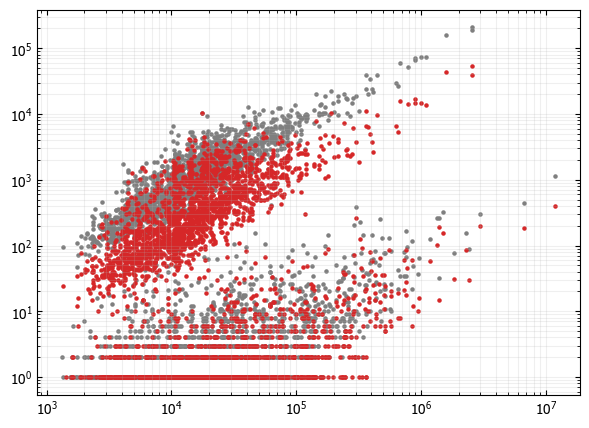

In [66]:
fig, ax1 = plt.subplots(1,1, figsize=(7,5))

ax1.scatter(chr_df['POPULAÇÃO ESTIMADA'], chr_df["count"], color="tab:gray", s=5, ls='-', marker='o')
ax1.scatter(acute_df['POPULAÇÃO ESTIMADA'], acute_df["count"], color="tab:red", s=5, ls='-', marker='o')
#ax1.scatter(ext_df['POPULAÇÃO ESTIMADA'], ext_df["count"], color="tab:orange", s=5, ls='-', marker='o')

for axis in [ax1]:
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.grid(alpha=0.2, which='both')
    axis.tick_params(which='both', direction='in', top=True, right=True)

In [61]:
ext_df

,MUNIC_RES,count,CODMUN,POPULAÇÃO ESTIMADA
0,211130,480,211130,1088057.0
1,292740,53,292740,2568928.0
2,210005,52,210005,110506.0
3,210750,51,210750,152306.0
4,211120,49,211120,257414.0
...,...,...,...,...
250,221060,1,221060,40784.0
251,250600,1,250600,32522.0
252,292210,1,292210,17417.0
253,250690,1,250690,23621.0


In [30]:
# -- date
date = dt.date(2014,1,1)
dates = [date + relativedelta(months=i) for i in range(48)]

leitos_equip = defaultdict(lambda: [])
for cur_date in tqdm(dates):
    leitos_df = quant_leitos_per_mun(cur_date, cnes_engine)
    equip_df = quant_equip_per_mun(cur_date, cnes_engine)
    leitos_df = leitos_df.merge(equip_df, how='outer').fillna(0)
    leitos_df["TOTAL"] = leitos_df["QUANT_LEITOS"] + leitos_df["QUANT_EQUIP"]
    mapp = dict(zip(leitos_df["CODUFMUN"], leitos_df["TOTAL"]))
    for mun, valor in mapp.items():
        leitos_equip[mun].append(valor)

#cnes_leitos_df = quant_leitos_per_cnes(date, cnes_engine)
#cnes_equip_df = quant_equip_per_cnes(date, cnes_engine)
#mun_leitos_df = quant_leitos_per_mun(date, cnes_engine)
#mun_equip_df = quant_equip_per_mun(date, cnes_engine)
#cnes_prof_df = quant_profissionais_per_cnes(date, cnes_engine)
#mun_prof_df = quant_profissionais_per_mun(date, cnes_engine)

100%|██████████| 48/48 [02:59<00:00,  3.73s/it]


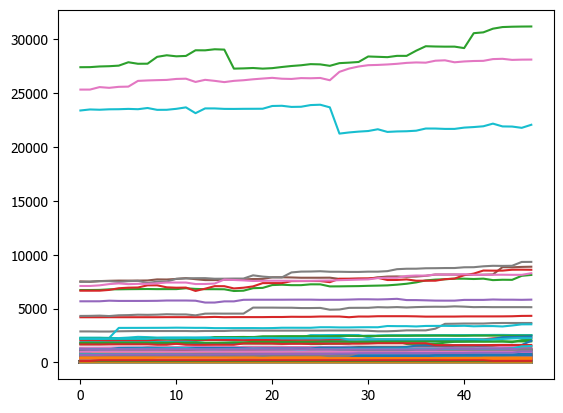

In [36]:
fig, ax = plt.subplots(1)

for mun in leitos_equip.keys():
    ax.plot(leitos_equip[mun])

#ax.set_ylim([0,6000])